In [465]:
#utilities
import numpy as np
import pandas as pd

import sklearn
import sklearn.metrics as sm
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report

#procesare fisiere(imagini)/director de imagini 
from os import listdir
from os.path import isfile, join

# pentru a putea prealua imagini si a le modifica in grayscale
from skimage import io,color

# pentru a realiza Discrete Wavelet Transform
import pywt
import pywt.data

# pentru a folosii cateva calcule statistice pe imaginile in domeniu frecventa
from scipy import stats

## Procesare date, un exemplu

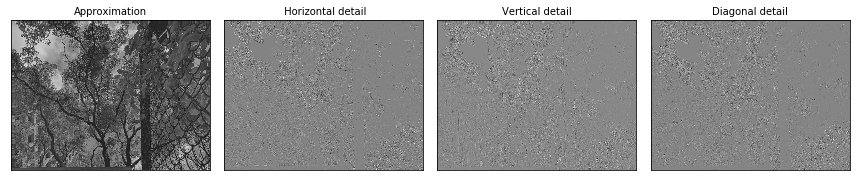

In [466]:
# Preluare imagine, in acest caz imagine realizata cu camera telefonului Google Pixel 
original = color.rgb2gray(io.imread("images\GP1_2.jpg"))

# Transformarea DWT(Discrete Waveles Transform), si afisarea detalilor obtinute
titles = ['Approximation', ' Horizontal detail','Vertical detail', 'Diagonal detail']

# aplicarea DWT, folosind Daubechies 8, dupa cum a fost specificat si in articolul stintific
coeffs2 = pywt.dwt2(original, 'db8')

#salvarea parametriilor 
LL, (LH, HL, HH) = coeffs2

fig = plt.figure(figsize=(12, 3))
for i, a in enumerate([LL, LH, HL, HH]):
    ax = fig.add_subplot(1, 4, i + 1)
    ax.imshow(a, interpolation="nearest", cmap=plt.cm.gray)
    ax.set_title(titles[i], fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])

fig.tight_layout()
plt.show()

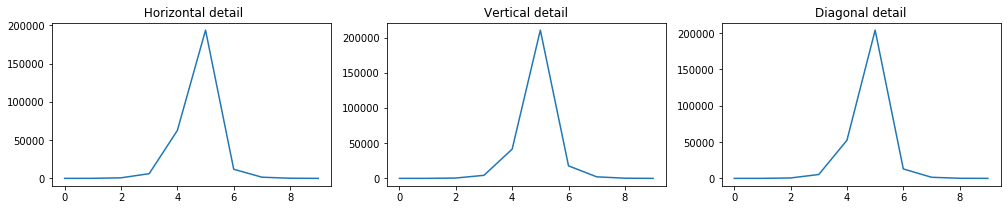

HH mean : 27739.9 
HH variance: 3694252008.8900003 
HH skewness: 2.3908195498575795 
HH kurtosis: 4.126677498697878 

LH mean : 27739.9 
LH variance: 3403082357.6900005 
LH skewness: 2.265225047410909 
LH kurtosis: 3.631758689584334 

HL mean : 27739.9 
HL variance: 3872896375.090001 
HL skewness: 2.4821566366570416 
HL kurtosis: 4.479625971657243 



In [467]:
titles = [' Horizontal detail','Vertical detail', 'Diagonal detail']

# calcularea histogramelor distributiilor din domeniu frecventa
HH_histogram = np.histogram(HH)
HL_histogram = np.histogram(HL)
LH_histogram = np.histogram(LH)

#afisarea acestora
hist_fig = plt.figure(figsize=(17, 3))
plt.subplot(131)
plt.plot(LH_histogram[0])
plt.title(titles[0])
plt.subplot(132)
plt.title(titles[1])
plt.plot(HL_histogram[0])
plt.subplot(133)
plt.plot(HH_histogram[0])
plt.title(titles[2])
plt.show()

# Un feature extraction exemplificator pentru fiecare distributie. 
# unde se preiau urmatoarele proprietati geometrice:
# mean -  reprezinta media aritmetica a tuturor valoriilor din histograma
# variance -  varianta reprezinta media deviatiilor patratice a unei variabile aleatoare de la media sa
# skewness - reprezinta asimetria unei distributii fata de 
# kurtosis -  masoara 'sparsity'-ul imaginii, spunand daca histograma este plata sau 'peaky'

mean = np.mean(HH_histogram[0])
variance = np.var(HH_histogram[0])
skewness = stats.skew(HH_histogram[0])
kurtosis = stats.kurtosis(HH_histogram[0])
#standard_deviation = np.std(HH_histogram[0])

print('HH mean :',mean,'\nHH variance:',variance,'\nHH skewness:',skewness,'\nHH kurtosis:',kurtosis,'\n')

mean1 = np.mean(LH_histogram[0])
variance1 = np.var(LH_histogram[0])
skewness1 = stats.skew(LH_histogram[0])
kurtosis1 = stats.kurtosis(LH_histogram[0])

print('LH mean :',mean1,'\nLH variance:',variance1,'\nLH skewness:',skewness1,'\nLH kurtosis:',kurtosis1,'\n')

mean2 = np.mean(HL_histogram[0])
variance2 = np.var(HL_histogram[0])
skewness2 = stats.skew(HL_histogram[0])
kurtosis2 = stats.kurtosis(HL_histogram[0])

print('HL mean :',mean2,'\nHL variance:',variance2,'\nHL skewness:',skewness2,'\nHL kurtosis:',kurtosis2,'\n')

## Feature Extraction (Wavelet Feature Extraction)

In [468]:
# am construit aceasta clasa pentru a automatiza procesul de extractie de caracteristici pentru fiecare imagine
# aceasta clasa va avea ca input un filepath si va returna proprietatiile geometrice pentru fiecare dintre cele 3 distributii 
# reiesite din DWT
# output-ul este reprezentat dintr-un rand apartinand datasetului
# outputul este de forma grupari de cate 4 caracteristici(mean,variance,skewness,kurtosis) pentru fiecare distributie DWT, 
# concatenate rezultand 12 caracteristici, iar la final se adauga denumirea cod a deviceu-lui care a realizat fotografia

class WaveletFeatureExtraction:
    
    def __init__(self, filepath):
        self.filepath = filepath
    
    def collect_data(self):
        image = io.imread(self.filepath)
        gray = color.rgb2gray(image)
        coefficients = pywt.dwt2(gray, 'db8') 
        LL, (LH, HL, HH) = coefficients
        row = []
        for i in [LH, HL, HH]:
            hist = np.histogram(i)
            mean = np.mean(hist[0])
            variance = np.var(hist[0])
            skewness = stats.skew(hist[0])
            kurtosis = stats.kurtosis(hist[0])
            row = np.concatenate((row,[mean,variance,skewness,kurtosis]))
        row = np.concatenate((row,[self.filepath[7:10]]))
        return row
    
    def change_path(self,newpath):
        self.filepath = newpath
        #print(self.filepath)
    
    def show_gray_image(self):
        io.imshow(self.gray)

In [469]:
# un test, pentru exemplificare
# unde SN3 este numele cod pentru Samsung Note 3
wavelet_extractor = WaveletFeatureExtraction(filepath="images\SN3_2.jpg")
wavelet_extractor.collect_data()

array(['27739.9', '2843657175.4900002', '2.0988989067762205',
       '2.9851777689399466', '27739.9', '3609594250.290001',
       '2.4124018325599477', '4.216952028636647', '27739.9',
       '3909754574.8900003', '2.485131875381358', '4.487600303284054',
       'SN3'], dtype='<U32')

In [470]:
# continutul fisierului cu imagine folosite pentru a creea datasetul
# unde GP1 reprezinta imagini realizate cu Google Pixel 
#      IPH reprezinta imagini realizate cu Iphone 11
#      N10 reprezinta imagini realizate cu Samsung Note 10
#      S8P reprezinta imagini realizate cu Samsung 8 Plus
#      SN3 reprezinta imagini realizate cu Samsung Note 3
onlyfiles = [f for f in listdir("images") if isfile(join("images", f))]
onlyfiles

['GP1_1.jpg',
 'GP1_2.jpg',
 'GP1_3.jpg',
 'GP1_4.jpg',
 'GP1_5.jpg',
 'GP1_6.jpg',
 'GP1_7.jpg',
 'IPH_1.jpg',
 'IPH_2.jpg',
 'IPH_4.jpg',
 'IPH_5.jpg',
 'IPH_6.jpg',
 'IPH_7.jpg',
 'N10_1.jpg',
 'N10_2.jpg',
 'N10_3.jpg',
 'N10_4.jpg',
 'N10_5.jpg',
 'S8P_1.jpg',
 'S8P_2.jpg',
 'S8P_3.jpg',
 'S8P_4.jpg',
 'S8P_5.jpg',
 'S8P_6.jpg',
 'S8P_7.jpg',
 'S8P_8.jpg',
 'SN3_1.jpg',
 'SN3_2.jpg',
 'SN3_3.jpg',
 'SN3_4.jpg',
 'SN3_5.jpg',
 'SN3_6.jpg',
 'SN3_7.jpg',
 'SN3_8.jpg']

In [271]:
# am construit aceasta clasa pentru a procesa directorul in care se afla imaginile folosite pentru a realiza dataset-ul
# Input: are ca intrare numele unui director
# Output: Dataset-ul avand caracteristicile pentru fiecare imagine 
class CreateDataset:
    
    def __init__(self,directory):
        self.directory = directory
        
    def extract_features_from_every_image_in_dir(self):
        images = [f for f in listdir(self.directory) if isfile(join(self.directory, f))]
        dataset = []
        i = 0
        wavelet_extractor = WaveletFeatureExtraction(filepath="")
        for img in images:
            row=[]
            i=i+1
            wavelet_extractor.change_path("images\\" + img)
            row = wavelet_extractor.collect_data()
            dataset = np.append(dataset,row)
        dataset = dataset.reshape(i,13)
        return dataset   

In [272]:
# utilizarea acestuia pentru a obtine dataset-ul
cd = CreateDataset(directory="images")
dataset = cd.extract_features_from_every_image_in_dir()

In [273]:
# folosirea panda pentru a putea vizualiza dataset-ul
# astfel ne rezulta din 32 de imagini 32*4*3 caracteristici(features) + 32 de denumiri ale device-urilor.
df = pd.DataFrame({'Mean': [i[0] for i in dataset], 
                   'Variance_LH': [i[1] for i in dataset],
                   'Skewness_LH': [i[2] for i in dataset],
                   'Kurtosis_LH':[i[3] for i in dataset], 
                   'Variance_HL': [i[5] for i in dataset],
                   'Skewness_HL': [i[6] for i in dataset],
                   'Kurtosis_HL':[i[7] for i in dataset], 
                   'Variance_HH': [i[9] for i in dataset],
                   'Skewness_HH': [i[10] for i in dataset],
                   'Kurtosis_HH':[i[11] for i in dataset],
                   'Device':[i[12] for i in dataset]})
df

,Mean,Variance_LH,Skewness_LH,Kurtosis_LH,Variance_HL,Skewness_HL,Kurtosis_HL,Variance_HH,Skewness_HH,Kurtosis_HH,Device
0,27739.9,3022937562.49,1.817732429502382,1.7178060558320034,5285203013.49,2.62764932480718,4.9831809767555875,3582407894.29,2.2967042287920347,3.747508079067928,GP1
1,27739.9,3403082357.6900005,2.265225047410909,3.631758689584334,3872896375.090001,2.4821566366570416,4.479625971657243,3694252008.8900003,2.3908195498575795,4.126677498697878,GP1
2,27739.9,5155127359.09,2.5792009377069576,4.812756548616456,6555104392.890001,2.6655723088953067,5.107685989375073,5946509935.89,2.6471152242158733,5.047501152190868,GP1
3,27739.9,3916275165.09,2.3750410697909667,4.050699821814056,5051212115.290001,2.605758508521412,4.907677999538739,3523391702.4900007,2.027601401658165,2.6178407360673637,GP1
4,27739.9,2346587996.8900003,1.520415282717358,0.457633099286165,2490408886.0900006,1.4995323031823935,0.3188799546904493,3594384003.4900007,2.472840465970928,4.46315944495575,GP1
5,27739.9,3307568131.29,2.224194400260686,3.4620104240501997,4544330882.290001,2.5936694813403793,4.873255354908574,4090252128.290001,2.4717784337757913,4.4267893223932075,GP1
6,27739.9,2665987057.2900004,1.9859888038343996,2.525757799646586,2947707805.8900003,2.2168151440685033,3.479625645960012,2981030018.8900003,2.252015098878169,3.631676676370697,GP1
7,307293.7,726949168235.21,2.643984968940601,5.037067795133245,823825941299.0099,2.6662003057466093,5.109653092364885,792794650810.4099,2.664530611532229,5.1044086632140715,IPH
8,307293.7,739988370301.61,2.652007756857189,5.063732538615378,808964073672.01,2.6654096184974265,5.107161841493022,379085182864.81006,1.519812882258623,0.34234227441706766,IPH
9,307293.7,697937960984.8099,2.652815898155813,5.06661997702364,587514979981.21,2.5046801177229923,4.541199020189167,615942047251.21,2.55494639460177,4.72568710251481,IPH


In [274]:
# exportarea dataset-ului pentru a putea fi folosit independent de sistem
#df.to_csv(r"dataset.csv")

## Implementarea Binary Logistic Regression


In [429]:
#testarea LR implementat, folosind dataset-ul iris
import seaborn as sns
import sklearn.datasets as datasets
from sklearn import preprocessing
from numpy import random

iris = datasets.load_iris()
X, y = iris.data, iris.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1234,shuffle= True)


In [430]:
class LogisticRegression:
    
    #constructorul seteaza default un learning_rate si un numar de iteratii folosit pentru gasirea minimului local mai jos
    def __init__(self, learning_rate=0.001, n_iters=1000):
        self.lr = learning_rate
        self.n_iters = n_iters
        self.weights = None
        self.bias = None
    
    # fit reprezinta metoda de antrenament
    def fit(self, X, y):
        n_samples, n_features = X.shape

        # ponderile sun initializate cu niste valori aleatoare, iar biasul este lasat 0 
        self.weights = np.random.rand(n_features)
        self.bias = 0

        # gradient descent este folosit pentru a determina daca sa gasit un minim local
        for _ in range(self.n_iters):
            # pentru a realiza un model liniar al ecuatiei de baza f(w,b) = X*weight+bias, folosim 
            # np.dot care ne realizeaza automat in functie de shape-ul inputului X produsul scalar
            linear_model = np.dot(X, self.weights) + self.bias
            # Pentru a clasificat valoarea categorica a modelului liniar se realizeaza operatia de sigmoid pe acesta
            y_predicted = self._sigmoid(linear_model)

            # calcularea gradientului
            # derivative_weights reprezinta derivata de ordin 1 al ponderilor(weights), care ne da informatii
            # daca ne apropiem de minimul local.
            # 
            derivative_weights = (1 / n_samples) * 2* np.dot(X.T, (y_predicted - y))
            derivative_bias = (1 / n_samples) * 2* np.sum(y_predicted - y)
            # folosind derivatele de mai sus, actualizam ponderile si bias-urile.
            self.weights -= self.lr * derivative_weights
            self.bias -= self.lr * derivative_bias
    
    # odata antrenata, folosind metoda predict putem aproxima un rezultat pentru a vedea cat bine s-au actualizat 
    # parametrii de weight si bias.
    def predict(self, X):
        linear_model = np.dot(X, self.weights) + self.bias
        y_predicted = self._sigmoid(linear_model)
        y_predicted_cls = [1 if i > 0.5 else 0 for i in y_predicted]
        return np.array(y_predicted_cls)
    
    # Aceasta functie returneaza o probabiliate aflata evident in intervalul [0,1]
    def _sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

In [431]:
def accuracy(y_true, y_pred):
    accuracy = np.sum(y_true == y_pred) / len(y_true)
    return accuracy

In [432]:
#Test LR
model = LogisticRegression()
model.fit(X_train, y_train)
predictions = model.predict(X_test)

print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        25
           1       0.33      1.00      0.50        25
           2       0.00      0.00      0.00        25

    accuracy                           0.33        75
   macro avg       0.11      0.33      0.17        75
weighted avg       0.11      0.33      0.17        75



In [433]:
print("LR accuracy", accuracy(y_test, predictions))

LR accuracy 0.3333333333333333


## Implementare K-Nearest Neighbours

In [434]:
def euclidean_distance(x1, x2):
        return np.sqrt(np.sum((x1 - x2)**2))

class KNN:
    
    # se initializeaza numarul de neighbours care vor fi verificati
    def __init__(self, k=3):
        self.k = k
    # se ataseaza datele de antrenament
    def fit(self, X, y):
        self.X_train = X
        self.y_train = y
    
    # pentru fiecare element din setul de intrare, se calculeaza cu ajutorul functiei helper _predict
    # comportamentul _predict este descris mai jos
    
    def predict(self, X):
        y_pred = [self._predict(x) for x in X]
        return np.array(y_pred)
    
    # _predict functie ce calculeaza urmatoarele:
    # 1. se calculeaza toate distantele dintre punctul x si datele de intrare de antrenament
    # 2. se sorteaza aceste distante, dupa index-ul lor, avand astfel pe primele k pozitii indicii celor k mai apropiati vecini
    # 3. se asigneaza labelurile folosind indecsi calculati mai sus folosind datele target
    # 4. se returneaza cel mai comun label din tabelul unidimensional al etichetelor gasite.
    
    def _predict(self, x):
        #1
        distances = [euclidean_distance(x, x_train) for x_train in self.X_train]
        #2
        k_index = np.argsort(distances)[:self.k]
        #3
        k_neighbor_labels = [self.y_train[i] for i in k_index]  
        #4
        most_common = Counter(k_neighbor_labels).most_common(1)
        return most_common[0][0]

In [435]:
from matplotlib.colors import ListedColormap
cmap = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

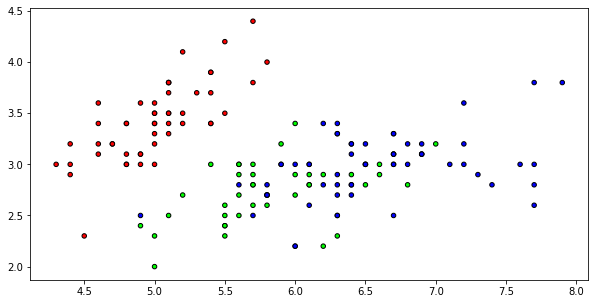

KNN accuracy 0.9666666666666667


In [436]:
X, y = iris.data, iris.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

plt.figure()
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap, edgecolor='k', s=20)
plt.show()

k = 5
clf = KNN(k=k)
clf.fit(X_train, y_train)
predictions = clf.predict(X_test)
print("KNN accuracy", accuracy(y_test, predictions))

## Rezultate folosind MLR(Multinominal Logistic Regression)

In [472]:
input_file = "dataset.csv"
data = pd.read_csv(input_file, header = 0)
data.head()

,Unnamed: 0,Mean,Variance_LH,Skewness_LH,Kurtosis_LH,Variance_HL,Skewness_HL,Kurtosis_HL,Variance_HH,Skewness_HH,Kurtosis_HH,Device
0,0,27739.9,3.022938e+09,1.817732,1.717806,5.285203e+09,2.627649,4.983181,3.582408e+09,2.296704,3.747508,GP1
1,1,27739.9,3.403082e+09,2.265225,3.631759,3.872896e+09,2.482157,4.479626,3.694252e+09,2.390820,4.126677,GP1
2,2,27739.9,5.155127e+09,2.579201,4.812757,6.555104e+09,2.665572,5.107686,5.946510e+09,2.647115,5.047501,GP1
3,3,27739.9,3.916275e+09,2.375041,4.050700,5.051212e+09,2.605759,4.907678,3.523392e+09,2.027601,2.617841,GP1
4,4,27739.9,2.346588e+09,1.520415,0.457633,2.490409e+09,1.499532,0.318880,3.594384e+09,2.472840,4.463159,GP1


In [482]:
from sklearn.preprocessing import StandardScaler

X = data.drop(["Device"],axis=1)
y = data["Device"]

scaler = StandardScaler()
scaler.fit(X)
X_s = scaler.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_s, y, test_size=0.8,shuffle=True)

In [483]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(solver='lbfgs',multi_class='ovr')
clf.fit(X_train,y_train)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='ovr', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [484]:
predicted = clf.predict(X_test)
print(classification_report(y_test,predicted))

              precision    recall  f1-score   support

         GP1       0.33      1.00      0.50         4
         IPH       0.00      0.00      0.00         6
         N10       0.00      0.00      0.00         5
         S8P       0.00      0.00      0.00         8
         SN3       0.31      1.00      0.48         5

    accuracy                           0.32        28
   macro avg       0.13      0.40      0.20        28
weighted avg       0.10      0.32      0.16        28



C:\Users\worka\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [485]:
confusion_matrix(y_test,predicted)

array([[4, 0, 0, 0, 0],
       [5, 0, 0, 0, 1],
       [1, 0, 0, 0, 4],
       [2, 0, 0, 0, 6],
       [0, 0, 0, 0, 5]], dtype=int64)

## Rezultate folosind KNN (sklearn)

In [486]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(y)
y_le = le.transform(y)

X_train, X_test, y_train, y_test = train_test_split(X_s, y_le,shuffle=True)

In [487]:
from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(X_train, y_train)

predicted = neigh.predict(X_test)

print(neigh.score(X_test,y_test))



0.4444444444444444


In [488]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, predicted)

0.4444444444444444

In [489]:
confusion_matrix(y_test,predicted)

array([[1, 0, 0, 0, 1],
       [0, 0, 0, 1, 0],
       [0, 1, 0, 0, 0],
       [0, 2, 0, 0, 0],
       [0, 0, 0, 0, 3]], dtype=int64)

## Rezultate folosind KNN implementat

In [490]:
k = 5
clf_imp = KNN(k=k)
clf_imp.fit(X_train, y_train)
predictions = clf_imp.predict(X_test)
print("KNN accuracy", accuracy(y_test, predictions))

KNN accuracy 0.4444444444444444
